In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: darkdev007
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 968MB/s]

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [4]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1, inplace=True)
print(data_df.shape)

(18185, 11)


In [5]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [6]:
data_df["Class"].unique()

array([1, 0])

In [7]:
data_df["Class"].value_counts()

,count
Class,
1,9985
0,8200


In [8]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [9]:
data_df.columns

Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness',
       'AspectRation', 'Class'],
      dtype='object')

In [10]:
X = data_df.drop(columns="Class").to_numpy()
Y = data_df["Class"].to_numpy()
Y

array([1., 1., 1., ..., 0., 0., 0.])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)

In [12]:
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state = 42)

In [13]:
X_train.shape, X_val.shape, X_test.shape

((12729, 10), (2728, 10), (2728, 10))

In [14]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype= torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]


In [15]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)


In [16]:
train_dataloader = DataLoader(
    dataset=training_data,
    batch_size = 8,
    shuffle = True
)
validation_dataloader = DataLoader(
    dataset=validation_data,
    batch_size = 8
)
testing_dataloader = DataLoader(
    dataset = testing_data,
    batch_size = 8
)

In [17]:
X.shape

(18185, 10)

In [18]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.input_layer = nn.Linear(in_features=X.shape[1], out_features=10)
    self.linear = nn.Linear(in_features=10, out_features=1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return self.sigmoid(self.linear(self.input_layer(x)))

model = MyModel().to(device)

In [19]:
X.shape

(18185, 10)

In [20]:
model

MyModel(
  (input_layer): Linear(in_features=10, out_features=10, bias=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [21]:
summary(model,
        (X.shape[1], ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [22]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [23]:
from tqdm.auto import tqdm
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in tqdm(range(epochs)):
  total_loss_train = 0
  total_loss_validation = 0
  total_acc_train = 0
  total_acc_validation = 0

  for X,y in train_dataloader:
    model.train()
    prediction = model(X).squeeze(1)

    loss = criterion(prediction,y)

    total_loss_train += loss.item()

    acc = ((prediction).round() == y).sum().item()

    total_acc_train += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.inference_mode():
    for X,y in validation_dataloader:
      prediction = model(X).squeeze(1)
      loss = criterion(prediction, y)

      total_loss_validation += loss.item()
      acc = ((prediction).round() == y).sum().item()

      total_acc_validation += acc

  total_loss_train_plot.append(round(total_loss_train/len(train_dataloader), 4))
  total_loss_validation_plot.append(round(total_loss_validation/len(validation_dataloader), 4))
  total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_validation/(validation_data.__len__())*100, 4))

  print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/len(train_dataloader):.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_validation/len(validation_dataloader):.4f} Validation Accuracy: {(total_acc_validation/(validation_data.__len__())*100):.4f}''')
  print("="*50)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch no. 1 Train Loss: 0.4228 Train Accuracy: 89.5043 Validation Loss: 0.1436 Validation Accuracy: 97.8372
Epoch no. 2 Train Loss: 0.0904 Train Accuracy: 98.4209 Validation Loss: 0.0615 Validation Accuracy: 98.6070
Epoch no. 3 Train Loss: 0.0556 Train Accuracy: 98.4995 Validation Loss: 0.0503 Validation Accuracy: 98.4971
Epoch no. 4 Train Loss: 0.0481 Train Accuracy: 98.5623 Validation Loss: 0.0473 Validation Accuracy: 98.3871
Epoch no. 5 Train Loss: 0.0450 Train Accuracy: 98.5702 Validation Loss: 0.0446 Validation Accuracy: 98.6070
Epoch no. 6 Train Loss: 0.0442 Train Accuracy: 98.4916 Validation Loss: 0.0458 Validation Accuracy: 98.3871
Epoch no. 7 Train Loss: 0.0436 Train Accuracy: 98.5545 Validation Loss: 0.0456 Validation Accuracy: 98.3871
Epoch no. 8 Train Loss: 0.0431 Train Accuracy: 98.5152 Validation Loss: 0.0438 Validation Accuracy: 98.6070
Epoch no. 9 Train Loss: 0.0432 Train Accuracy: 98.5231 Validation Loss: 0.0439 Validation Accuracy: 98.6437
Epoch no. 10 Train Loss: 0.0

In [24]:

with torch.inference_mode():
  total_loss_test = 0
  total_acc_test = 0
  for X,y in testing_dataloader:

    prediction = model(X).squeeze(1)

    loss= criterion((prediction), y)
    total_loss_test += loss.item()
    acc = ((prediction).round() == y).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")


Accuracy Score is: 99.08%


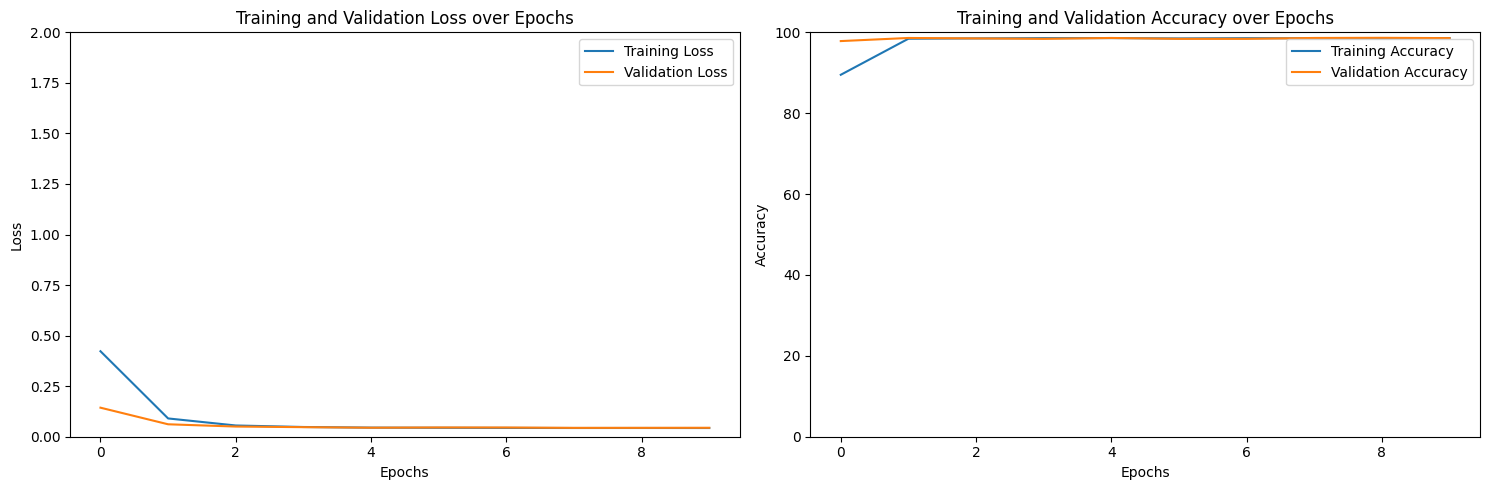

In [25]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [ ]:
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))